In [1]:
import sys, os
import numpy as np
import pandas as pd
import scipy.stats as stat
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
template_file = open('../template_script/enrichment_browser.R', 'r')
template_file_info = template_file.read()
template_file.close()

In [14]:
# load gene expression files in raw read count matrix format
expr_dir = '../data/Enrichment_browser_data/'
all_file = os.listdir(expr_dir)
all_file.sort()
all_file

['AARS.colData.tab',
 'AARS.exprs.tab',
 'AARS.rowData.tab',
 'AATF.colData.tab',
 'AATF.exprs.tab',
 'AATF.rowData.tab',
 'ABCF1.colData.tab',
 'ABCF1.exprs.tab',
 'ABCF1.rowData.tab',
 'ADAR.colData.tab',
 'ADAR.exprs.tab',
 'ADAR.rowData.tab',
 'AGO1.colData.tab',
 'AGO1.exprs.tab',
 'AGO1.rowData.tab',
 'AKAP1.colData.tab',
 'AKAP1.exprs.tab',
 'AKAP1.rowData.tab',
 'AKAP8.colData.tab',
 'AKAP8.exprs.tab',
 'AKAP8.rowData.tab',
 'AKAP8L.colData.tab',
 'AKAP8L.exprs.tab',
 'AKAP8L.rowData.tab',
 'APOBEC3C.colData.tab',
 'APOBEC3C.exprs.tab',
 'APOBEC3C.rowData.tab',
 'ASCC1.colData.tab',
 'ASCC1.exprs.tab',
 'ASCC1.rowData.tab']

In [15]:
pathway_file = '../pathway_files/K562_DESEq2.gmt'

In [16]:
# directory for storing all output results
result_dir = '../example_results/Enrichment_browser_results/'
# write the scripts for each target to a seperate R script to enable parallel running
script_dir = '../example_scripts/Enrichment_browser_scripts/'

In [17]:
added_target = set()
for expr_file in all_file:
    target = expr_file.split('.')[0]
    if target in added_target:
        continue
    new_template_info = template_file_info.replace('DATA_DIR.txt', expr_dir)
    new_template_info = new_template_info.replace('PATHWAY_FILE', pathway_file)
    new_template_info = new_template_info.replace('TARGET', target)
    new_template_info = new_template_info.replace('OUTPUT_FILE', result_dir+target+'.ebrowser_result.txt')
    script = open(script_dir+target+'.r', 'w')
    script.write(new_template_info)
    script.close()   
    added_target.add(target)

Run the R scripts. And the results will be saved in example_results/Enrichment_browser_results/

In [29]:
# extract Enrichment browser results
all_result_file = os.listdir(result_dir)
all_result_file.sort()
out_file = open('../example_results/enrichment_browser_result.txt', 'w')
for file in all_result_file:
    target = file.split('.')[0]
    df = pd.read_csv(result_dir+file, sep='\t')
    # the result file of enrichment browser is already sorted
    # just need to get the index of the target
    rank = np.where(df['GENE.SET']==target)[0][0]+1
    out_file.write(target+'\t'+str(rank)+'\n')
out_file.close() 

In [2]:
# plot the results
result_df = pd.read_csv('../example_results/enrichment_browser_result.txt', header=None, sep='\t', index_col=0)
result_df.columns = ['Correct pathway rank']
result_df

,Correct pathway rank
0,
AARS,3
AATF,1
ABCF1,1
ADAR,2
AGO1,11
AKAP1,1
AKAP8,25
AKAP8L,9
APOBEC3C,7


In [3]:
def apk(predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average precision at k between two lists of items.
    """
    total_num = len(predicted)
    precision_list = []
    for idx in range(k):
        precision_list.append(np.where(predicted<=idx+1)[0].shape[0]/total_num)
        # print(np.where(predicted<=idx+1)[0].shape[0])
    # return P@10 and AP@10
    return precision_list[-1], np.mean(precision_list)

Median rank:  2.5
Precision@10:  0.8
Average Precision@10:  0.6199999999999999


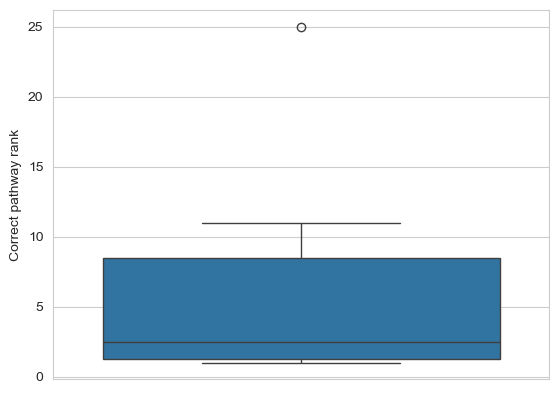

In [4]:
sns.boxplot(data=result_df['Correct pathway rank'])
print('Median rank: ', result_df['Correct pathway rank'].median())
print('Precision@10: ', apk(result_df['Correct pathway rank'])[0])
print('Average Precision@10: ', apk(result_df['Correct pathway rank'])[1])

<AxesSubplot: xlabel='Correct pathway rank', ylabel='Percent'>

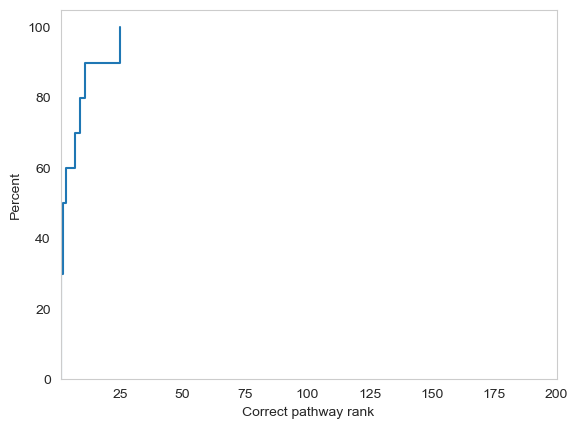

In [5]:
plt.grid(False)
plt.xlim(1, 200)
# plt.ylim(0, 100)
sns.ecdfplot(data=result_df['Correct pathway rank'], stat='percent')